_version log: Creating nice plot. Branch of V39_

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import patches
from PIL import Image
import pandas as pd
import os, re, sys
from scipy import interpolate as sciinter, signal as scisig, optimize as sciopt, ndimage as sciimage #scipy has a lot of submodules
from astropy.io import fits
plt.rcParams.update({'font.size':14})
np.set_printoptions(threshold=sys.maxsize)

c = 299_792_458 #m/s
camera = "purple" #"manta" "xeva" "purple"
file_type = ".fts" # the manta uses .tif, the xeva uses .csv, the purple camera can export .tif or .fts
dead_pixels = 0.1 # % of most anomalous pixels to replace with its nearest neighbour
zero_padding = 4 #factor to extrapolate the interferogram by. 1 means no extrapolation. 2 means that the interferogram will double in length. This should interpolate the spectrum rather than improving resolution.
apodization_function = [None, "box", "crop", "triangular", "happ-genzel", "blackmann-harris"]#. None and "box" are identical unless you add zero-padding.

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

In [17]:
#################FUNCTIONS##################

def none2zero(x): #x should be an interger or None
    return int(x or bool(x)) #a simple if statement would work best but I think this is cooler.

def line(x,A,B):
    return A + B*x
     
def cubic(x,A,B,C,D):
     return A + B*x + C*x**2 + D*x**3

def cubic_residuals(x, y, A, B, C, D):
    return cubic(x, A, B, C, D) - y

def recip(x):
    return c*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa. 

def format_ticks(x, pos):
    return f"{x:.1f}"  # Format the tick label with two decimal places

def find_best_peak(interferograms, height=None, threshold=None, distance=None, width=None, wlen=None, rel_height=0.5, plateau_size=None):
    if interferograms.ndim == 1:
        peaks, peaks_properties = scisig.find_peaks(interferograms, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = peaks[best_peak_index]
        peak_properties = {key: value[best_peak_index] for key, value in peaks_properties.items()}
    
    elif interferograms.ndim == 2:
        interferograms = interferograms.transpose() #Use the right set of axes.
        peaks, peaks_properties = scisig.find_peaks(interferograms[0], height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = [peaks[best_peak_index]]
        peak_properties = {key: [value[best_peak_index]] for key, value in peaks_properties.items()}

        for interferogram in interferograms[1:]:
            peaks, peaks_properties = scisig.find_peaks(interferogram, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
            best_peak_index = np.argmax(peaks_properties["prominences"])
            peak = np.concatenate([peak, [peaks[best_peak_index]]])
            peak_properties = {key: peak_properties[key] +[value[best_peak_index]] for key, value in peaks_properties.items()}

    else:
        raise IndexError("find_best_peak expected interferograms to have 1 or 2 dimentions. Got {0:}".format(interferograms.ndim))
    return peak, peak_properties


def angular_slice(phi, FT2d, width= 1):

    diameter = int(np.sum(np.array(FT2d.shape)**2)**0.5) #The length of the diagonal. This is the largest diameter that we will need.
    x = np.arange(-diameter//2, diameter//2) *np.cos(phi) +FT2d.shape[1]//2
    x = np.concatenate([x + np.sin(phi) * i for i in np.arange(-width//2 +1, width//2 +1)])
    y = np.arange(-diameter//2, diameter//2) *np.sin(phi) +FT2d.shape[0]//2
    y = np.concatenate([y + np.cos(phi) * i for i in np.arange(-width//2 +1, width//2 +1)])
    coords = np.vstack((y,x))

    FT1d = sciimage.map_coordinates(FT2d, coords, mode= "constant", cval= np.nan)
    FT1d = FT1d.reshape(width, diameter)
    FT1d = FT1d.sum(axis=0)
    FT1d = FT1d[~np.isnan(FT1d)] #delete nan values
    FT1d = FT1d[:2*(len(FT1d)//2)] #only works with even lengths otherwise the ft is not symetrical. (IDK why)

    mean = np.nanmean(np.abs(FT1d)) #np.mean should also be ok because the nans have been removed

    return mean, FT1d

def angular_intergral(phi, FT2d): #function for scipy minimization
    mean, _ = angular_slice(phi, FT2d)
    return -mean #I acually want the maximum.


def zero_pad(interferogram, zero_padding):
    original_length = len(interferogram)
    interferogram = np.concatenate([[interferogram[0]] *int((zero_padding-1) *original_length //2), interferogram])
    interferogram = np.concatenate([interferogram, [interferogram[-1]] *int((zero_padding-1) *original_length //2)])
    return interferogram

def apodization(interferogram, max_index, function = None, L = None):
    if L == None: # The defult definition of L is dependent on interferogram so it must be assigned after interferogram is defined.
        L = len(interferogram) # L is the length of the region to apodize over. The zero-padded region lies outside L
    else:
        max_index += (zero_padding-1) *L //2 # because the interferogram has been extended, the max_index has changed.

    index = np.arange(0, len(interferogram)) # We need indexes if we want to apply apodization

    if None in function:
        interferogram = interferogram # leave unchanged
    if "box" in function:
        box_function = [1 if i >= (zero_padding-1) *L //2 and i < (zero_padding+1) *L //2 else 0 for i in index] # apply boundries. interferogram is invalid in zero-padded regions.
        box_function = np.array(box_function)
        interferogram = interferogram * box_function
    if "crop" in function:
        is_positive, is_negative = interferogram>=0, interferogram<0
        becomes_negative = np.logical_and(is_negative, np.roll(is_positive, 1))
        becomes_postive = np.logical_and(np.roll(is_negative, 1), is_positive)
        change_sign = np.logical_or(becomes_negative, becomes_postive)
        change_sign_indexes = np.arange(0,len(interferogram))[change_sign]
        start_index = change_sign_indexes[0]
        end_index = change_sign_indexes[-1]
        crop_function = [1 if i >= start_index and i < end_index else 0 for i in index] # apply boundries. interferogram is invalid beyond where it crosses zero.
        crop_function = np.array(crop_function)
        interferogram = interferogram * crop_function
    if "triangular" in function:
        triangular_function = 1 - np.abs(2/L *(index-max_index)) #definition of function
        triangular_function = [y if y >= 0 else 0 for y in triangular_function] #apply boundries. Negative values are invalid.
        triangular_function = np.array(triangular_function)
        interferogram = interferogram * triangular_function
    if "happ-genzel" in function:
        happ_genzel_function = 0.54 +0.46*np.cos(np.pi/L *(index-max_index)) #definition of function
        happ_genzel_function = [happ_genzel_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.08 for i in index] #apply boundries. Only the first period of the cosine is valid.
        happ_genzel_function = np.array(happ_genzel_function)
        interferogram = interferogram * happ_genzel_function
    if "blackmann-harris" in function:
        blackmann_harris_function = 0.42323 +0.49755*np.cos(np.pi/L *(index-max_index)) +0.07922*np.cos(2*np.pi/L *(index-max_index)) #definition of function. This is the 3-term blackmann-harris.
        blackmann_harris_function = [blackmann_harris_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.0049 for i in index] #apply boundries. Only the first period of the cosine is valid.
        blackmann_harris_function = np.array(blackmann_harris_function)
        interferogram = interferogram * blackmann_harris_function
    
    return interferogram

def find_fringes_files(colour, number, file_type):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        check = re.findall('^'+colour+'_fringes'+number+'_*[0-9]*'+file_type , file_name)

        if len(check) != 0:
            new_file_names = new_file_names + [file_name]
            try:
                file_number = re.findall('_[0-9]+' , file_name)[0] #readings done with the delay line should look like this.
            except IndexError:
                file_number = "_0" #readings done without the delay line don't have a '_number' appendix.
            new_file_numbers = new_file_numbers + [int(file_number[1:])] #string indexing! Removes the '_' and saves the file number
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_fringes_arrays(file_names, camera, file_type):
    if camera == "manta":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        angles = np.array(im, dtype= np.float32)
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            Array = np.array(im, dtype= np.float32)
            angles = np.dstack([angles,Array])
    elif camera == "xeva":
        angles = np.loadtxt('data\\'+file_names[0], dtype= np.float32, delimiter=";")
        for file_name in file_names[1:]: #for every other interferogram
            Array = np.loadtxt('data\\'+file_name, dtype= np.float32, delimiter=";")
            angles = np.dstack([angles,Array])
    elif camera == "purple" and file_type == ".tif":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        angles = np.array(im, dtype= np.float32)[:,:,0]
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            Array = np.array(im, dtype= np.float32)[:,:,0]
            angles = np.dstack([angles,Array])
    elif camera == "purple" and file_type == ".fts":
        angles_hdulist = fits.open('data\\'+file_names[0],  ignore_missing_end=True)
        angles = np.array(angles_hdulist[0].data)
        angles_hdulist.close()
        for file_name in file_names[1:]: #for every other interferogram
            angles_hdulist = fits.open('data\\'+file_name,  ignore_missing_end=True)
            Array = np.array(angles_hdulist[0].data)
            angles_hdulist.close()
            angles = np.dstack([angles,Array])

    return angles  

def import_standard_photo(colour, number, camera, file_type):
    if camera == "manta":
        im = Image.open('data\\'+colour+'_BA'+number+file_type)
        beamA = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_BB'+number+file_type)
        beamB = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_bg'+number+file_type)
        background = np.array(im, dtype= np.float32)
    elif camera == "xeva":
        beamA = np.loadtxt('data\\'+colour+'_BA'+number+file_type, delimiter=";")
        beamB = np.loadtxt('data\\'+colour+'_BB'+number+file_type, delimiter=";")
        background = np.loadtxt('data\\'+colour+'_bg'+number+file_type, delimiter=";")
    elif camera == "purple" and file_type == ".tif":
        im = Image.open('data\\'+colour+'_BA'+number+file_type)
        beamA = np.array(im, dtype= np.float32)[:,:,0] #The purple camera has colour channels dispite it being monochromatic.
        im = Image.open('data\\'+colour+'_BB'+number+file_type)
        beamB = np.array(im, dtype= np.float32)[:,:,0]
        im = Image.open('data\\'+colour+'_bg'+number+file_type)
        background = np.array(im, dtype= np.float32)[:,:,0]
    elif camera == "purple" and file_type == ".fts":
        BA_hdulist = fits.open('data\\'+colour+'_BA'+number+file_type,  ignore_missing_end=True)
        beamA = np.array(BA_hdulist[0].data)
        BA_hdulist.close()
        BB_hdulist = fits.open('data\\'+colour+'_BB'+number+file_type,  ignore_missing_end=True)
        beamB = np.array(BB_hdulist[0].data)
        BB_hdulist.close()
        bg_hdulist = fits.open('data\\'+colour+'_bg'+number+file_type,  ignore_missing_end=True)
        background = np.array(bg_hdulist[0].data)
        bg_hdulist.close()

    file_names, _ = find_fringes_files(colour= colour, number= number, file_type= file_type)
    fringes = combine_fringes_arrays(file_names= file_names, camera= camera, file_type= file_type)

    return fringes, beamA, beamB, background

def dead_pixel_filter(interferogram):
    # Remove the most anomalous 1% of pixels and replace with nearest nearbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(interferogram <= np.percentile(interferogram,upper_percentile), interferogram >= np.percentile(interferogram,lower_percentile) )
    coords = np.mgrid[0:interferogram.shape[0], 0:interferogram.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = sciinter.NearestNDInterpolator(coords[notdead], interferogram[notdead])
    interferogram = nearest(coords[:,:,0],coords[:,:,1])

    return interferogram

def bg_subtract(fringes, beamA, beamB, background):
    if fringes.ndim == 3:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            for n in np.arange(0,beamPost.shape[2]):
                beamPost[:,:,n] = dead_pixel_filter(beamPost[:,:,n]) #I can't figure out how to vectorise this bit :/

        beamPost = np.subtract(beamPost, np.mean(beamPost, axis= (0,1)), casting= "safe")

    elif fringes.ndim == 2:
        nofringes = beamA +beamB -background #ignore the error
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            beamPost = dead_pixel_filter(beamPost)
        beamPost = np.subtract(beamPost, np.mean(beamPost), casting= "safe")

    return beamPost, nofringes

def Coeffients2Amplitudes(FT, freqs):
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

def average_interferogram(interferogram_2D):
    interferogram_1D = np.mean(interferogram_2D, axis = 0)
    maximum,_ = find_best_peak(interferogram_1D) #find the center of the fringes
    maximums_offset = (interferogram_2D.shape[1]//2) - maximum #the center of the fringes might not be in the center of the image
    return interferogram_1D, maximum, maximums_offset

def pick_centered_interferogram(maximums_offsets, fringes, fringes_processed, fringes_averaged, nofringes, maximums):
    reference_index = np.argmin(np.abs(maximums_offsets))

    if fringes.ndim == 3:
        reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = fringes[:,:,reference_index], fringes_processed[:,:,reference_index], fringes_averaged[:,reference_index], maximums_offsets[reference_index], nofringes[:,:,reference_index]
    elif fringes.ndim == 2: # only 1 fringes file found
        reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = fringes, fringes_processed, fringes_averaged, maximums_offsets, nofringes

    return reference, reference_processed, reference_averaged, reference_offset, reference_nofringes

def estimate_best_S2N(interferogram_averaged, fringe_width_estimate = 50):
    df = pd.DataFrame(interferogram_averaged, columns= ["interferogram"])

    peak_index, peak_properties = scisig.find_peaks(df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
    df.loc[peak_index, "max"] = peak_properties["peak_heights"]
    df["max"].interpolate(inplace=True)
    peak_index, peak_properties = scisig.find_peaks(-df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
    df.loc[peak_index, "min"] = -peak_properties["peak_heights"]
    df["min"].interpolate(inplace=True)

    df["range"] = df["max"] - df["min"]

    peak_index, _ = find_best_peak(df["range"], height = 0, width = 0, rel_height= 0.9)

    return peak_index, df["range"][peak_index]

def FFT2D_slice_interferogram(interferogram2D):
    FT2d = np.fft.fftshift(np.fft.fft2(interferogram2D, norm= "forward"))

    minimisation_results = sciopt.minimize(angular_intergral, x0= 0, args= FT2d, bounds= [[-np.pi/4, np.pi/4]]) #Assume that the fringes are vertical to within 45 degrees. This avoids the strong line at 90 and -90 degrees. (Where does this line come from?)
    min_phi, min_intergral = minimisation_results.x, minimisation_results.fun
    _, FT1d = angular_slice(min_phi, FT2d, width= 1)
    interferogram1D = np.fft.ifft(np.fft.fftshift(FT1d), norm= "forward")
    
    return interferogram1D

def spectralFFT(interferogram1D, theta):

    FT = np.fft.fft(interferogram1D, norm = "forward")
    freqs = np.fft.fftfreq(len(FT), pixel_pitch)
    amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

    corrected_wavelengths = wavelengths *2*np.sin(theta)
    corrected_frequencys = recip(corrected_wavelengths)

    amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise
    
    return amplitude, corrected_wavelengths, corrected_frequencys

def delay_line_angle(interferograms_averaged, interferograms_maximums, delay_line_delta, delay_line_bounds = [1, -1]):

    delay_line_travel = np.arange(interferograms_averaged.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /c
    time_delay *= 1e9 #convert from us to fs

    #we found the maximums earlier

    all_peak_estimates = interferograms_maximums[delay_line_bounds[0]:delay_line_bounds[1]]
    time_delays = time_delay[delay_line_bounds[0]:delay_line_bounds[1]]

    popt, pcov = sciopt.curve_fit(line, all_peak_estimates, time_delays)

    m = popt[1]
    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to us/um (= s/m)
    theta = np.arcsin(c *np.abs(m) /2 ) 

    return theta


In [18]:
###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

manta_data = import_normalised_csv("mantra_spectrum.csv", 0)
manta_data[:,0] = recip(manta_data[:,0]*1e-3) #convert nm to THz
manta_function = sciinter.interp1d(manta_data[:,0], manta_data[:,1], fill_value= np.nan, bounds_error= False)

purple_data = import_normalised_csv("PV320_spectrum.csv", 0)
purple_data[:,0] = recip(purple_data[:,0]*1e-3) #convert nm to THz
purple_function = sciinter.interp1d(purple_data[:,0], purple_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] = recip(ir_data[:,0]*1e-3) #convert nm to THz
ir_function = sciinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] = recip(big_data[:,0]*1e-3) #convert nm to THz
big_function = sciinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def camera_function(x, camera):
        return (manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))


def manufacturers_function(x, source, camera):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))

def spectral_responce_normalisation(amplitude, frequencies, source, camera):
        percentagediff = (manufacturers_function(frequencies[:-1], source, camera) - amplitude[:-1]) /amplitude[:-1]
        amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 10) +1 #re-scale to fit

        normalised_amplitude = amplitude / camera_function(frequencies, camera) #factor in the camera sensitivity
        return normalised_amplitude

In [19]:

def process_data(source, run, camera, file_type, delay_line_delta= 2):

    if camera == "manta":
        pixel_pitch = 9.9 #um
    elif camera == "xeva":
        pixel_pitch = 20 #um
    elif camera == "purple":
        pixel_pitch = 48.5 #um
    elif camera == "pyro":
        pixel_pitch = 80 #um
    else:
        raise ValueError(camera + " is not a valid camera.")

    fringes, beamA, beamB, background = import_standard_photo(source, run, camera, file_type)
    fringes_processed, nofringes = bg_subtract(fringes, beamA, beamB, background)
    fringes_averaged, maximums, maximums_offsets = average_interferogram(fringes_processed)
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = pick_centered_interferogram(maximums_offsets, fringes, fringes_processed, fringes_averaged, nofringes, maximums)
    reference_maximum, _ = estimate_best_S2N(reference_averaged)
    reference_sliced = FFT2D_slice_interferogram(reference_processed)
    reference_zeropadded = zero_pad(reference_sliced, zero_padding)
    reference_apodized = apodization(reference_zeropadded, reference_maximum, function= apodization_function, L= len(reference_sliced))
    theta = delay_line_angle(fringes_averaged, maximums, delay_line_delta, delay_line_bounds= [2,-1])
    amplitude, corrected_wavelengths, corrected_frequencys = spectralFFT(reference_apodized, theta)
    normalised_amplitude = spectral_responce_normalisation(amplitude, corrected_frequencys, source, camera)

    return reference_processed, corrected_frequencys, normalised_amplitude, reference_sliced

to_plot_purple, to_plot_purple_freqs, to_plot_purple_amps, to_plot_purple_1d = process_data("big", "18", "purple", ".fts", delay_line_delta= 2)
to_plot_xeva, to_plot_xeva_freqs, to_plot_xeva_amps, to_plot_xeva_1d = process_data("big", "13", "xeva", ".csv", delay_line_delta= 5)


C:\Users\syf83691\AppData\Local\Temp\ipykernel_17380\1473675509.py:248: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs
C:\Users\syf83691\AppData\Local\Temp\ipykernel_17380\2022856146.py:34: RuntimeWarning: divide by zero encountered in divide
  normalised_amplitude = amplitude / camera_function(frequencies, camera) #factor in the camera sensitivity
C:\Users\syf83691\AppData\Local\Temp\ipykernel_17380\1473675509.py:248: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs


C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\syf83691\AppData\Local\Temp\ipykernel_17380\1473675509.py:16: RuntimeWarning: divide by zero encountered in divide
  return c*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa.


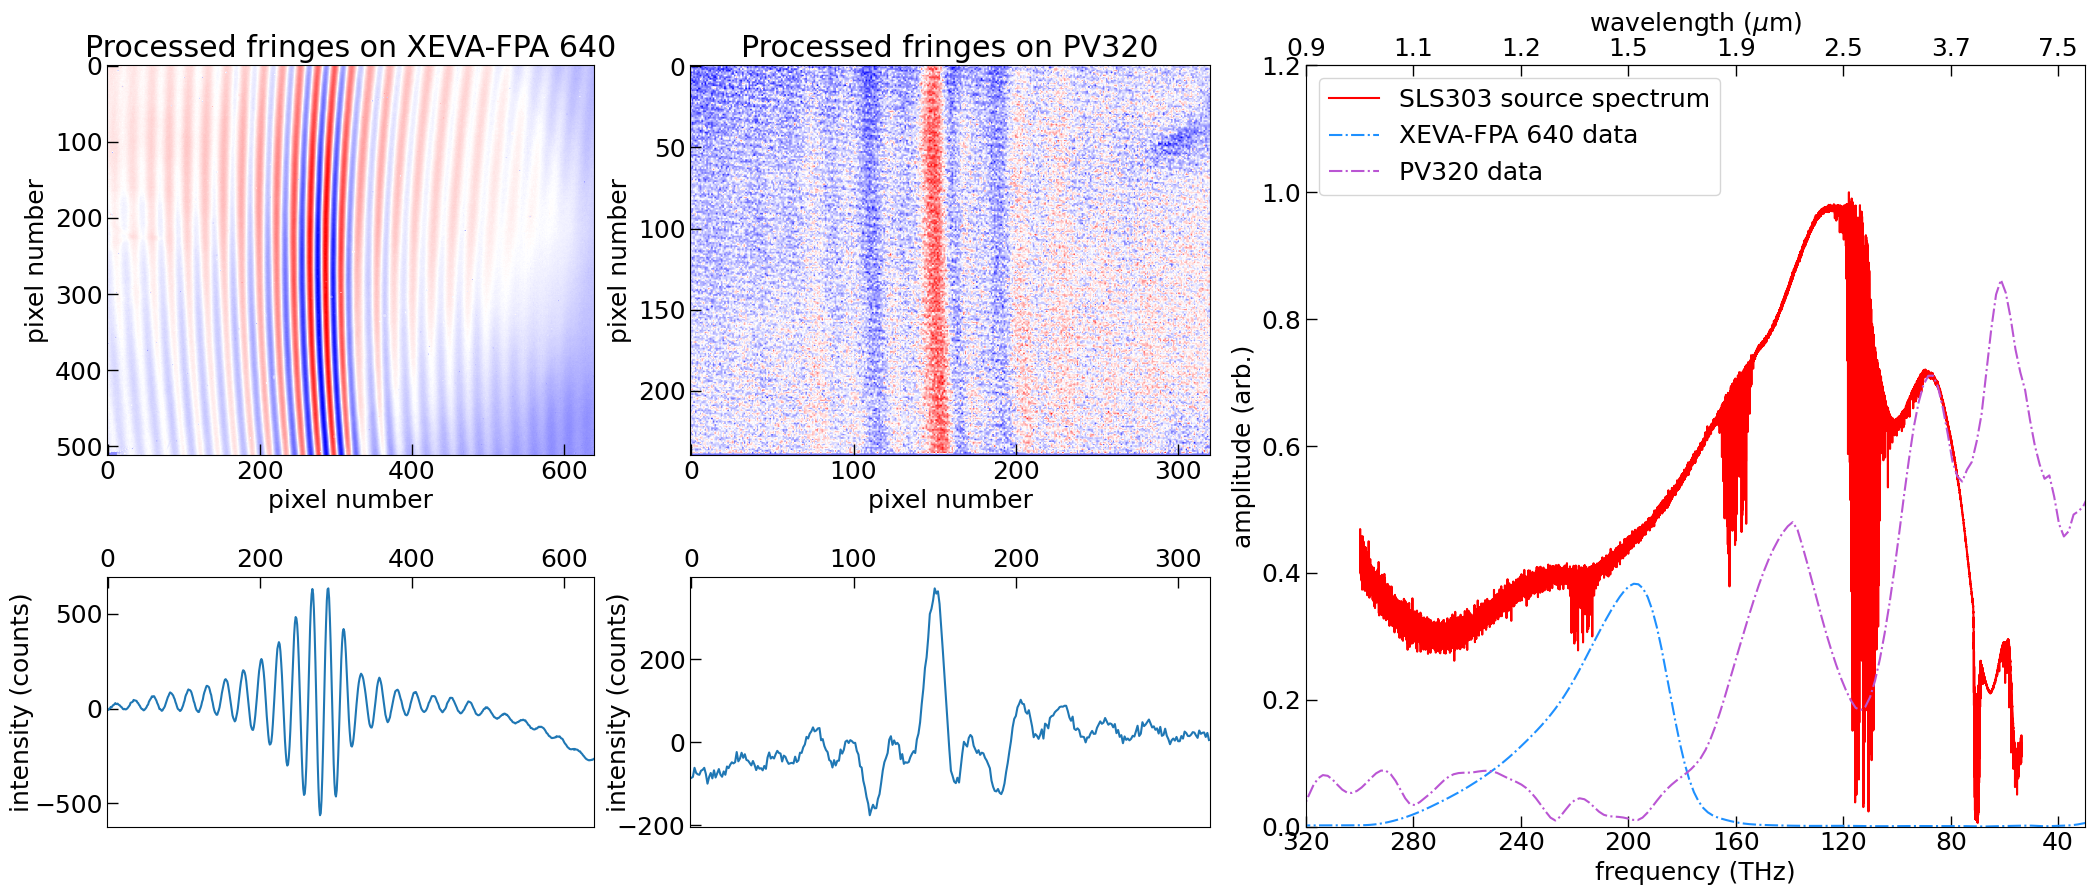

In [20]:
frequency_limits = [30,320] #THz

axs_mosaic = [["a)", "b)", "e)"],
              ["c)", "d)", "e)"]]

purple_aspect_ratio = to_plot_purple.shape[1] /to_plot_purple.shape[0]
xeva_aspect_ratio = to_plot_xeva.shape[1] /to_plot_xeva.shape[0]


plt.rcParams.update({'font.size':18})
fig, axs = plt.subplot_mosaic(axs_mosaic, figsize= (21,9), width_ratios= [xeva_aspect_ratio, purple_aspect_ratio, 2], height_ratios= [1, 0.5])

[ax.tick_params(direction= "in", length= 8, width= 1) for ax in axs.values()] #dictionary comprehention! Applies the function to every axis apart from secax.
#[ax.set_title(label, loc='left') for label, ax in axs.items()] #Each `item` in a dictionary has a pair of `keys` and `values`. dict= {item1, item2, item3}. item1 = key1: value1
[ax.set_anchor("NW") for ax in axs.values()] 

axs["a)"].imshow(to_plot_xeva, cmap='bwr')
axs["a)"].set(xlabel= "pixel number", ylabel= "pixel number", title= "Processed fringes on XEVA-FPA 640")

axs["c)"].plot(to_plot_xeva_1d)
axs["c)"].sharex(axs["a)"])
axs["c)"].tick_params(bottom= False, labelbottom= False, top= True, labeltop= True)
axs["c)"].set_ylabel("intensity (counts)", labelpad= 0)

axs["b)"].imshow(to_plot_purple, cmap='bwr')
axs["b)"].set(xlabel= "pixel number", ylabel= "pixel number", title= "Processed fringes on PV320")

axs["d)"].plot(to_plot_purple_1d)
axs["d)"].sharex(axs["b)"])
axs["d)"].tick_params(bottom= False, labelbottom= False, top= True, labeltop= True)
axs["d)"].set_ylabel("intensity (counts)", labelpad= -10)

axs["e)"].plot(big_data[:,0],
                big_data[:,1],
                label = "SLS303 source spectrum",
                color = "red")
axs["e)"].plot(to_plot_xeva_freqs,
                to_plot_xeva_amps *0.7,
                label = "XEVA-FPA 640 data",
                color = "dodgerblue",
                linestyle = "-.")
axs["e)"].plot(to_plot_purple_freqs,
                to_plot_purple_amps,
                label = "PV320 data",
                color = "mediumorchid",
                linestyle = "-.")

###customise axis
secax = axs["e)"].secondary_xaxis('top', functions=(recip, recip))

axs["e)"].set_xlabel('frequency (THz)')
axs["e)"].set_xticks([40,80,120,160,200,240,280,320])
secax.set_xlabel('wavelength ($\mu$m)')
secax.set_xticks(recip(np.array([40,80,120,160,200,240,280,320])))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
secax.tick_params(direction= "in", length= 8, width= 1) #secax in not a part of the axs dictionary so it didn't get the memo.

axs["e)"].set(ylabel= 'amplitude (arb.)', ylim= (0,1.2), xlim= frequency_limits[::-1])
axs["e)"].legend(loc= "upper left")

plt.tight_layout(pad= 0.5)
plt.show()